# Learning how to use GNN

## data preparation for node classification

In [39]:
import torch
import torch.nn.functional as F
import networkx as nx
import numpy as np
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.nn import GCNConv, VGAE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Load the Toy Dataset

In [2]:
graph_path = "./student_graph.graphml"
graph_nx = nx.read_graphml(graph_path)
print(graph_nx)

Graph with 100 nodes and 678 edges


Text(0.5, 1.0, 'Student Graph')

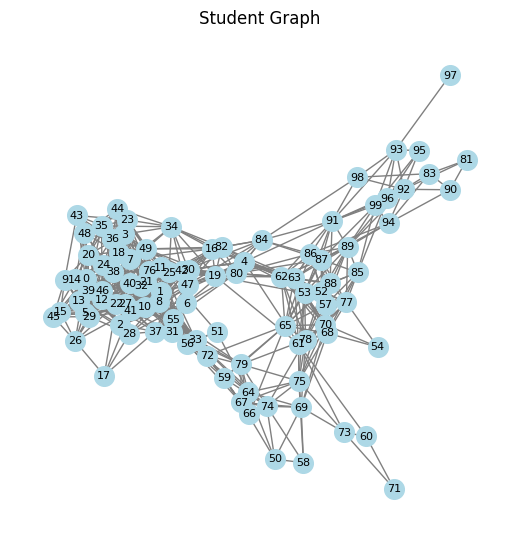

In [3]:
# plot the graph

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(graph_nx, seed=42)  # positions for all nodes
nx.draw(graph_nx, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=8)
plt.title("Student Graph")

In [4]:
graph_nx.nodes(data=True)

NodeDataView({'0': {'name': 'Student_0', 'club': 'Sports', 'like_sports': 0.7955415097609702, 'like_music': 0.22092986130263698, 'like_science': 0.043229593031232666}, '1': {'name': 'Student_1', 'club': 'Sports', 'like_sports': 0.5391393734668835, 'like_music': 0.4639886213674777, 'like_science': 0.10628242488369519}, '2': {'name': 'Student_2', 'club': 'Sports', 'like_sports': 0.7570436693055108, 'like_music': 0.01738607217224325, 'like_science': 0.44273534523038927}, '3': {'name': 'Student_3', 'club': 'Sports', 'like_sports': 0.788508191930243, 'like_music': 0.5265848394724645, 'like_science': 0.19326163051929218}, '4': {'name': 'Student_4', 'club': 'Sports', 'like_sports': 0.485804022702344, 'like_music': 0.4568754444233814, 'like_science': 0.49032284631155887}, '5': {'name': 'Student_5', 'club': 'Sports', 'like_sports': 0.7096290234245467, 'like_music': 0.16079924755089806, 'like_science': 0.006686683810232519}, '6': {'name': 'Student_6', 'club': 'Sports', 'like_sports': 0.463712645

Each node corresponds to a student with the following attributes : 
- Name
- club
- like_sports
- like_music
- like_science

Edges correspond to friendship between students

### Convert from networkx to pytorch geometric 

In [5]:
# convertion from networkx to pytorch geometric
graph_nx.graph = {}
data = from_networkx(graph_nx, group_node_attrs=["like_sports","like_music","like_science"])

### Check what is inside this object

In [6]:
print(data)
print(data.num_nodes)
print(data.x)
print(data.edge_index)

Data(edge_index=[2, 1356], name=[100], club=[100], x=[100, 3])
100
tensor([[7.9554e-01, 2.2093e-01, 4.3230e-02],
        [5.3914e-01, 4.6399e-01, 1.0628e-01],
        [7.5704e-01, 1.7386e-02, 4.4274e-01],
        [7.8851e-01, 5.2658e-01, 1.9326e-01],
        [4.8580e-01, 4.5688e-01, 4.9032e-01],
        [7.0963e-01, 1.6080e-01, 6.6867e-03],
        [4.6371e-01, 6.7684e-02, 4.6283e-01],
        [7.8664e-01, 2.9709e-01, 3.8989e-01],
        [5.0010e-01, 3.6287e-01, 1.0783e-01],
        [8.7970e-01, 1.7788e-01, 1.2040e-01],
        [5.3466e-01, 3.7802e-01, 0.0000e+00],
        [6.5995e-01, 5.9280e-01, 1.3134e-01],
        [7.6446e-01, 1.6210e-01, 1.9845e-01],
        [8.9997e-01, 9.2499e-02, 2.4825e-01],
        [9.1519e-01, 1.3469e-01, 2.7405e-01],
        [7.5238e-01, 9.4697e-03, 2.0946e-02],
        [5.1735e-01, 4.1870e-01, 4.1152e-01],
        [4.3422e-01, 6.9311e-02, 1.3107e-01],
        [8.0739e-01, 4.6717e-01, 2.5192e-02],
        [4.9686e-01, 5.4837e-01, 3.1980e-01],
        [8.63

### Encode the class club

In [7]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.club)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.club))
print(data.y)  # tensor of class labels
print(data.num_classes)  # number of unique classes

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
3


Clubs are now encoded as 0, 1 or 2 for each node

### Hide like information for some nodes

 Let’s consider that for some of the students, we don’t know their preferences, but we want to
 train a model to guess the club they belong to. For instance, we can imagine new students to whom
 we want to recommend a club. So we want to guess the club class from the
 like attributes, but
 for students for which we don’t have the like attribute.

In [8]:
num_nodes = data.num_nodes
train_ratio = 0.80 # 80% of nodes for training
# Randomly creating a mask
mask = torch.rand(num_nodes) < train_ratio
data.train_mask = mask
data.test_mask = ~data.train_mask
# remove the attributes for the nodes that are not in the training set
temp = torch.zeros((num_nodes, 3), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp

## Predict using a GCN

###  Build your first GCN, with a single layer

In [9]:
class GCN(torch.nn.Module):
    """
    Simple GCN model with a single graph convolutional layer.
    ------
    Parameters
        num_node_features : int*
            Number of input features per node.
        num_classes : int, default=3
            Number of output classes.
    ------
    Returns
        Log probabilities for each class.
    """
    def __init__(self, num_node_features, num_classes=3):
        """
        Initialize the GCN model.
        """
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_classes)

    def forward(self, data):
        """
        Forward pass of the GCN model.
        ------
        Parameters
            data : torch_geometric.data.Data*
                Input graph data containing node features and edge indices.
        ------
        Returns
            Log probabilities for each class.
        """
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        return F.log_softmax(x, dim=1)

### Your evaluation should be only on the test set

In [10]:
def train(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

In [11]:
def evaluate(model, data, verbose=True):
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')

    if verbose: # print the targets and predictions for all nodes
        print("Targets:", data.y.tolist())
        print("Predictions:", pred.tolist())
        
    return acc, pred

### Check the add_self_loops attributes of the conv layer

Add self-loops to the input graph : this allow to add a 1 on the diagonal of the adjancy matrix A (Â) and on the degree matrix D (D^), so that the results of the convolution are symmetrical

### Print the targets and the predictions for all the nodes

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=data.num_node_features, num_classes=data.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss() # Negative Log Likelihood Loss for multi-class classification

train(model, data, optimizer, criterion, epochs=1000)
acc, pred = evaluate(model, data, verbose=True)

Epoch 0, Loss: 1.0833
Epoch 20, Loss: 0.9895
Epoch 40, Loss: 0.9827
Epoch 60, Loss: 0.9264
Epoch 80, Loss: 0.9581
Epoch 100, Loss: 0.9243
Epoch 120, Loss: 0.9061
Epoch 140, Loss: 0.8662
Epoch 160, Loss: 0.9140
Epoch 180, Loss: 0.8688
Epoch 200, Loss: 0.8464
Epoch 220, Loss: 0.8239
Epoch 240, Loss: 0.8968
Epoch 260, Loss: 0.7694
Epoch 280, Loss: 0.8880
Epoch 300, Loss: 0.8431
Epoch 320, Loss: 0.8682
Epoch 340, Loss: 0.8206
Epoch 360, Loss: 0.7875
Epoch 380, Loss: 0.8302
Epoch 400, Loss: 0.8291
Epoch 420, Loss: 0.7781
Epoch 440, Loss: 0.8082
Epoch 460, Loss: 0.7802
Epoch 480, Loss: 0.7044
Epoch 500, Loss: 0.8040
Epoch 520, Loss: 0.7871
Epoch 540, Loss: 0.8165
Epoch 560, Loss: 0.8948
Epoch 580, Loss: 0.8324
Epoch 600, Loss: 0.7977
Epoch 620, Loss: 0.7789
Epoch 640, Loss: 0.7929
Epoch 660, Loss: 0.8032
Epoch 680, Loss: 0.7624
Epoch 700, Loss: 0.6657
Epoch 720, Loss: 0.7926
Epoch 740, Loss: 0.7771
Epoch 760, Loss: 0.8394
Epoch 780, Loss: 0.6940
Epoch 800, Loss: 0.8025
Epoch 820, Loss: 0.794

### Confusion Matrix

<Axes: >

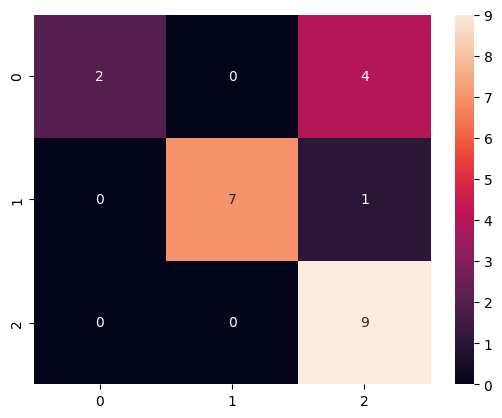

In [25]:
confmat = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
sns.heatmap(confmat, annot=True, fmt='g')

5 nodes mal classés

### Print the weights of the GCN layer and interpret them

In [26]:
# print the weights of the GCN layer 
print(model.conv1.lin.weight) 

Parameter containing:
tensor([[ 5.1789e-02, -7.0979e-04, -1.3767e-06],
        [-2.2650e+00, -2.7280e+00,  4.0817e+00],
        [ 3.5480e+00, -2.2613e+00, -1.3744e+00]], requires_grad=True)


###  Print the network using networkx

[('0', {'name': 'Student_0', 'club': 'Sports', 'like_sports': 0.7955415097609702, 'like_music': 0.22092986130263698, 'like_science': 0.043229593031232666, 'pred_club': np.str_('Sports'), 'preference': np.str_('like_sports')}), ('1', {'name': 'Student_1', 'club': 'Sports', 'like_sports': 0.5391393734668835, 'like_music': 0.4639886213674777, 'like_science': 0.10628242488369519, 'pred_club': np.str_('Sports'), 'preference': np.str_('like_sports')}), ('2', {'name': 'Student_2', 'club': 'Sports', 'like_sports': 0.7570436693055108, 'like_music': 0.01738607217224325, 'like_science': 0.44273534523038927, 'pred_club': np.str_('Sports'), 'preference': np.str_('like_sports')}), ('3', {'name': 'Student_3', 'club': 'Sports', 'like_sports': 0.788508191930243, 'like_music': 0.5265848394724645, 'like_science': 0.19326163051929218, 'pred_club': np.str_('Sports'), 'preference': np.str_('like_sports')}), ('4', {'name': 'Student_4', 'club': 'Sports', 'like_sports': 0.485804022702344, 'like_music': 0.45687

Text(0.5, 1.0, 'Student Graph\n(Predicted Clubs)')

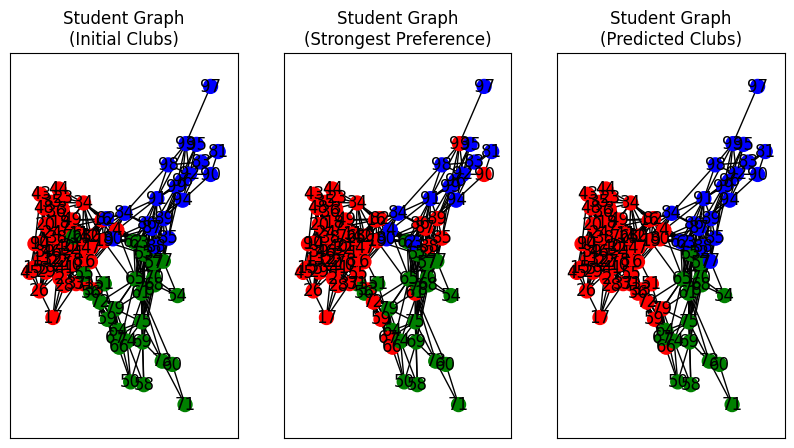

In [33]:
# node colors corresponding first to student’s preference, before and after prediction
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(graph_nx, seed=42)

# before prediction
plt.subplot(1, 3, 1)

nx.set_node_attributes(graph_nx,dict(zip(range(len(data.club)),data.club)),"club")
colors = []
for node in graph_nx.nodes(data=True):
    if node[1]['club'] == 'Sports':
        colors.append('red')
    elif node[1]['club'] == 'Music':
        colors.append('green')
    else:
        colors.append('blue')
# edge_colors = ['black' if pred[edge[0]] == pred[edge[1]] else 'gray' for edge in graph_nx.edges()]
nx.draw_networkx(graph_nx,with_labels=True,width=1,node_size=100,node_color=colors, pos=pos)
plt.title("Student Graph\n(Initial Clubs)")

# before prediction with color as the strongest preference 
plt.subplot(1, 3, 2)
pref = ['like_sports', 'like_music', 'like_science']
nodes_attr = data.x.numpy()
max_pref = np.array([pref[np.argmax(node)] for node in nodes_attr])
nx.set_node_attributes(graph_nx, dict(zip(graph_nx.nodes(), max_pref)), "preference")
print(graph_nx.nodes(data=True))
colors = []
for node in graph_nx.nodes(data=True):
    if node[1]['preference'] == 'like_sports':
        colors.append('red')
    elif node[1]['preference'] == 'like_music':
        colors.append('green')
    else:
        colors.append('blue')
# edge_colors = ['black' if pred[edge[0]] == pred[edge[1]] else 'gray' for edge in graph_nx.edges()]
nx.draw_networkx(graph_nx,with_labels=True,width=1,node_size=100,node_color=colors, pos=pos)
plt.title("Student Graph\n(Strongest Preference)")

# after prediction
plt.subplot(1, 3, 3)

pred_club = encoder.inverse_transform(pred.cpu())
print(pred_club)
nx.set_node_attributes(graph_nx, dict(zip(graph_nx.nodes(), pred_club)), "pred_club")
print(graph_nx.nodes(data=True))

colors = []
for node in graph_nx.nodes(data=True):
    if node[1]['pred_club'] == 'Sports':
        colors.append('red')
    elif node[1]['pred_club'] == 'Music':
        colors.append('green')
    else:
        colors.append('blue')
# edge_colors = ['black' if pred[edge[0]] == pred[edge[1]] else 'gray' for edge in graph_nx.edges()]
nx.draw_networkx(graph_nx,with_labels=True,width=1,node_size=100,node_color=colors, pos=pos)
plt.title("Student Graph\n(Predicted Clubs)")

Quelque misclassification là où les nodes sont "proches"

## Predicting edges using a VGAE

### Predict edges

In [37]:
# start back from the initial network without hidden info
graph_nx = nx.read_graphml(graph_path)
data = from_networkx(graph_nx, group_node_attrs=["like_sports","like_music","like_science"])

encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.club)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.club))

# building train/test split for edges without validation set
data = train_test_split_edges(data, val_ratio=0.0, test_ratio=0.2)


c:\Users\matth\anaconda3\envs\torch-xpu\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


### Encoder

In [38]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logstd = GCNConv(2*out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

### VGAE model

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGAE(Encoder(data.num_node_features, 2)).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

### Evaluation of the model

In [41]:
def test_model(model, data):
    z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

In [42]:
def train_model(model, data, optimizer, epochs=200):
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        z = model.encode(data.x, data.train_pos_edge_index)
        loss = model.recon_loss(z, data.train_pos_edge_index)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            auc, ap = test_model(model, data)
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')
            
    return model

In [43]:
# evaluate the model
model = train_model(model, data, optimizer, epochs=200)
auc, ap = test_model(model, data)
print(f'Final AUC: {auc:.4f}, AP: {ap:.4f}')

Epoch 10, Loss: 1.8222, AUC: 0.5653, AP: 0.5620
Epoch 20, Loss: 1.4662, AUC: 0.6084, AP: 0.5843
Epoch 30, Loss: 1.3959, AUC: 0.5401, AP: 0.5397
Epoch 40, Loss: 1.3896, AUC: 0.5123, AP: 0.5228
Epoch 50, Loss: 1.4100, AUC: 0.4712, AP: 0.4792
Epoch 60, Loss: 1.3932, AUC: 0.6059, AP: 0.5917
Epoch 70, Loss: 1.3629, AUC: 0.6646, AP: 0.6711
Epoch 80, Loss: 1.3594, AUC: 0.7357, AP: 0.7056
Epoch 90, Loss: 1.2793, AUC: 0.7838, AP: 0.7830
Epoch 100, Loss: 1.2391, AUC: 0.7956, AP: 0.7645
Epoch 110, Loss: 1.1779, AUC: 0.8069, AP: 0.7531
Epoch 120, Loss: 1.1253, AUC: 0.8184, AP: 0.7692
Epoch 130, Loss: 1.1291, AUC: 0.7962, AP: 0.7465
Epoch 140, Loss: 1.1068, AUC: 0.8315, AP: 0.7983
Epoch 150, Loss: 1.1129, AUC: 0.8140, AP: 0.7729
Epoch 160, Loss: 1.1033, AUC: 0.8016, AP: 0.7118
Epoch 170, Loss: 1.1180, AUC: 0.8089, AP: 0.7730
Epoch 180, Loss: 1.0816, AUC: 0.8122, AP: 0.7393
Epoch 190, Loss: 1.1093, AUC: 0.8087, AP: 0.7480
Epoch 200, Loss: 1.1027, AUC: 0.8196, AP: 0.7852
Final AUC: 0.8149, AP: 0.7615

Scores are quite high

### Check that you are able to reconstruct the original graph

In [45]:
# reconstruct the original graph
def reconstruct_graph(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        Ahat = torch.sigmoid(z @ z.T)
    return Ahat 
adj = reconstruct_graph(model, data)
print(f"Reconstructed adjacency matrix: {adj}")

Reconstructed adjacency matrix: tensor([[0.9130, 0.8283, 0.7933,  ..., 0.1459, 0.1958, 0.0899],
        [0.8283, 0.7420, 0.7094,  ..., 0.2350, 0.2784, 0.1756],
        [0.7933, 0.7094, 0.6868,  ..., 0.2661, 0.3117, 0.2091],
        ...,
        [0.1459, 0.2350, 0.2661,  ..., 0.7906, 0.7422, 0.8508],
        [0.1958, 0.2784, 0.3117,  ..., 0.7422, 0.7036, 0.7997],
        [0.0899, 0.1756, 0.2091,  ..., 0.8508, 0.7997, 0.9073]])


### Using networkx, plot the original network, plus some of the edges considered as the most likely. You can use a color scale to represent the likeliness of observing an edge.

In [57]:
# Create mapping: assign integer IDs 0..N-1 to each node
mapping = {old_label: i for i, old_label in enumerate(graph_nx.nodes())}

# Relabel nodes
graph_nx = nx.relabel_nodes(graph_nx, mapping)

# Check
print("First 10 new node labels:", list(graph_nx.nodes())[:10])

First 10 new node labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


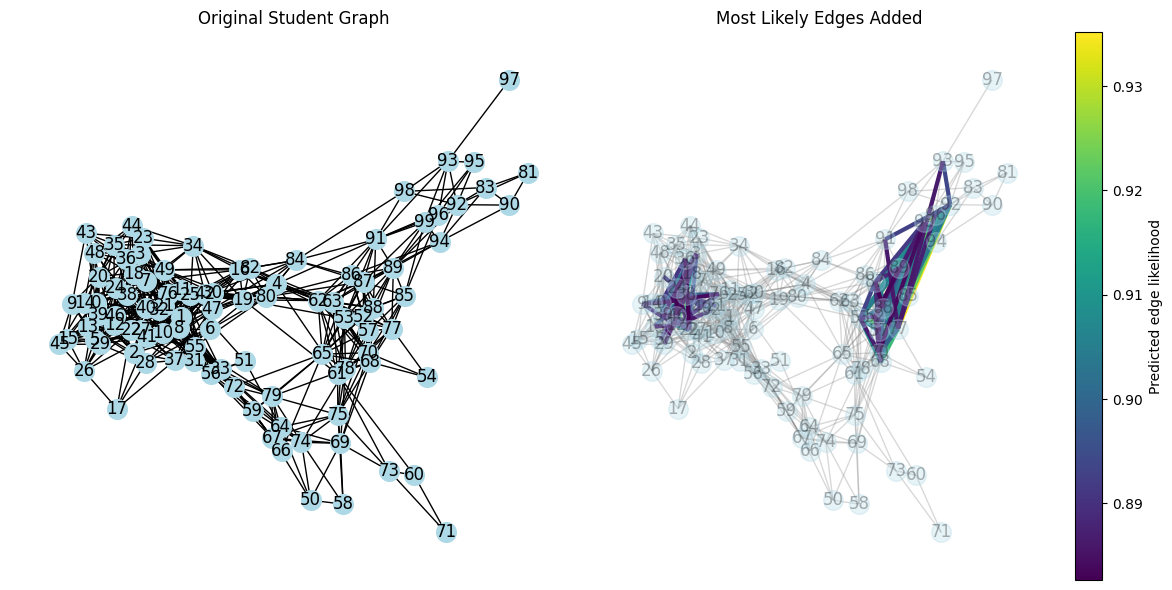

In [68]:
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(graph_nx, seed=42)

# --- Left: Original graph ---
ax1 = plt.subplot(1, 2, 1)
nx.draw(graph_nx, pos, with_labels=True, node_size=200, node_color='lightblue')
ax1.set_title("Original Student Graph")

# --- Right: Graph with predicted edges ---
ax2 = plt.subplot(1, 2, 2)

# Get edges + probabilities
edge_probs = []
for i in range(data.num_nodes):
    for j in range(i + 1, data.num_nodes):
        edge_probs.append((i, j, adj[i, j].item()))

# Take top N
N = 100
edge_probs = sorted(edge_probs, key=lambda x: x[2], reverse=True)[:N]
edges = [(i, j) for i, j, _ in edge_probs]
colors = [p for _, _, p in edge_probs]

# Normalize colors
norm = plt.Normalize(vmin=min(colors), vmax=max(colors))
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])

# Draw base graph + predicted edges
nx.draw(graph_nx, pos, with_labels=True, node_size=200, node_color='lightblue',
        edge_color='gray', width=1.0, alpha=0.3, ax=ax2)
nx.draw_networkx_edges(graph_nx, pos, edgelist=edges,
                       edge_color=colors, edge_cmap=plt.cm.viridis,
                       edge_vmin=min(colors), edge_vmax=max(colors),
                       width=3, ax=ax2)

# ✅ Attach colorbar to the right subplot
plt.colorbar(sm, ax=ax2, label='Predicted edge likelihood')

ax2.set_title("Most Likely Edges Added")
plt.tight_layout()
plt.show()